# Imports and Helper functions

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
import itertools
import json
import pickle
import seaborn as sns

# Disable warnings
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

# Set the style for the plots
sns.set_palette("pastel")

def load_and_preprocess_data(data_dir, valid_samples=100):
    """Loads the dataset, preprocesses it, and splits it into train, validation, and test sets."""
    images_folder = os.path.join(data_dir, "images")
    styles_path = os.path.join(data_dir, "styles.csv")

    df = pd.read_csv(styles_path, on_bad_lines="skip")
    df = df[df["id"].apply(lambda x: os.path.isfile(os.path.join(images_folder, str(x) + ".jpg")))]
    df["image"] = df["id"].apply(lambda x: os.path.join(images_folder, str(x) + ".jpg"))
    df = df[["image", "articleType"]]

    # Filter categories with at least valid_samples samples
    valid_categories = df["articleType"].value_counts()[df["articleType"].value_counts() >= valid_samples].index
    df = df[df["articleType"].isin(valid_categories)]

    # Split data into train, validation, and test sets
    train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df["articleType"], random_state=42)
    val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df["articleType"], random_state=42)
    
    # Calculate total number of images
    total_images = len(df)

    # Print the number of samples in each set
    print(f"Total number of images after filtering: {total_images}")
    print(f"Number of samples in train set: {len(train_df)}")
    print(f"Number of samples in validation set: {len(val_df)}")
    print(f"Number of samples in test set: {len(test_df)}")
    
    return train_df, val_df, test_df, total_images

def resize_with_padding(image, target_height, target_width):
    """Resizes the image to the target size with padding."""
    height, width = tf.shape(image)[0], tf.shape(image)[1]

    if tf.equal(height, 0) or tf.equal(width, 0):
        return tf.zeros([target_height, target_width, 3], dtype=tf.float32)

    scale = tf.minimum(
        tf.cast(target_width, tf.float32) / tf.cast(width, tf.float32),
        tf.cast(target_height, tf.float32) / tf.cast(height, tf.float32),
    )
    new_height = tf.cast(tf.cast(height, tf.float32) * scale, tf.int32)
    new_width = tf.cast(tf.cast(width, tf.float32) * scale, tf.int32)
    resized_image = tf.image.resize(image, [new_height, new_width])
    padded_image = tf.image.pad_to_bounding_box(
        resized_image,
        (target_height - new_height) // 2,
        (target_width - new_width) // 2,
        target_height,
        target_width,
    )
    return padded_image

def preprocess_image(image_path, target_size, preprocess_input_func):
    """Loads, resizes, and preprocesses a single image."""
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = resize_with_padding(image, target_size[0], target_size[1])
    image = preprocess_input_func(image)
    return image

def create_dataset(df, batch_size, target_size, preprocess_input_func, is_training=False):
    """Creates a TensorFlow dataset from the dataframe."""
    image_paths = df["image"].values
    labels = pd.get_dummies(df["articleType"]).values
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))

    if is_training:
        dataset = dataset.shuffle(buffer_size=len(df))

    dataset = dataset.map(
        lambda image_path, label: (preprocess_image(image_path, target_size, preprocess_input_func), label),
        num_parallel_calls=tf.data.AUTOTUNE,
    )
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

def build_model(model_name, input_shape, num_classes):
    """Builds and compiles the CNN model."""
    if model_name == "ResNet50":
        base_model = tf.keras.applications.ResNet50(weights="imagenet", include_top=False, input_shape=input_shape)
    elif model_name == "Xception":
        base_model = tf.keras.applications.Xception(weights="imagenet", include_top=False, input_shape=input_shape)
    elif model_name == "EfficientNetV2S":
        base_model = tf.keras.applications.EfficientNetV2S(weights="imagenet", include_top=False, input_shape=input_shape)
    elif model_name == "InceptionV3":
        base_model = tf.keras.applications.InceptionV3(weights="imagenet", include_top=False, input_shape=input_shape)
    else:
        raise ValueError(f"Unsupported model: {model_name}")

    # Make the last 30 layers trainable
    for layer in base_model.layers[-30:]:
        layer.trainable = True

    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(2048, activation="relu"),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(num_classes, activation="softmax"),
    ])

    model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=["accuracy"])
    return model

def train_model(model, model_name, train_dataset, val_dataset, epochs=30):
    """Trains the model and returns the training history."""
    model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
        f"best_model_{model_name}.keras",
        save_best_only=True,
        monitor="val_accuracy",
        mode="max",
        verbose=1
    )
    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, min_lr=1e-6),
        model_checkpoint
    ]

    history = model.fit(train_dataset, epochs=epochs, validation_data=val_dataset, verbose=1, callbacks=callbacks)
    return history

def plot_confusion_matrix(cm, classes, title='Confusion Matrix'):
    plt.figure(figsize=(30, 25))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    plt.tight_layout()
    

def plot_macro_average_prc_curve(true_labels, predicted_probs, class_labels, model_name):
    plt.figure(figsize=(10, 8))
    
    # Binarize the labels
    true_labels_bin = label_binarize(true_labels, classes=range(len(class_labels)))
    
    # Compute Precision-Recall curve and average precision for each class
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(len(class_labels)):
        precision[i], recall[i], _ = precision_recall_curve(true_labels_bin[:, i], predicted_probs[:, i])
        average_precision[i] = average_precision_score(true_labels_bin[:, i], predicted_probs[:, i])
    
    # Compute macro-average precision-recall curve
    precision["macro"], recall["macro"], _ = precision_recall_curve(true_labels_bin.ravel(), predicted_probs.ravel())
    average_precision["macro"] = average_precision_score(true_labels_bin, predicted_probs, average="macro")
    
    # Plot macro-average precision-recall curve
    plt.plot(recall["macro"], precision["macro"], 
             label=f'Macro-average PRC (AP = {average_precision["macro"]:.2f})',
             color='navy', linestyle='-', linewidth=2)

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Macro-Average Precision-Recall Curve for {model_name}')
    plt.legend(loc="lower left")
    plt.savefig(f'macro_avg_prc_{model_name}.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

    return average_precision["macro"]

E0000 00:00:1720002252.123626      13 common_lib.cc:798] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="localhost"
=== Source Location Trace: ===
learning/45eac/tfrc/runtime/common_lib.cc:479
D0703 10:24:12.132344363      13 config.cc:196]                        gRPC EXPERIMENT call_status_override_on_cancellation   OFF (default:OFF)
D0703 10:24:12.132359947      13 config.cc:196]                        gRPC EXPERIMENT call_v3                                OFF (default:OFF)
D0703 10:24:12.132363486      13 config.cc:196]                        gRPC EXPERIMENT canary_client_privacy                  ON  (default:ON)
D0703 10:24:12.132366115      13 config.cc:196]                        gRPC EXPERIMENT capture_base_context                   ON  (default:ON)
D0703 10:24:12.132368653      13 config.cc:196]                        gRPC EXPERIMENT client_idleness                        ON  (d

# Model Configuration

Total number of images after filtering: 42150
Number of samples in train set: 33720
Number of samples in validation set: 4215
Number of samples in test set: 4215


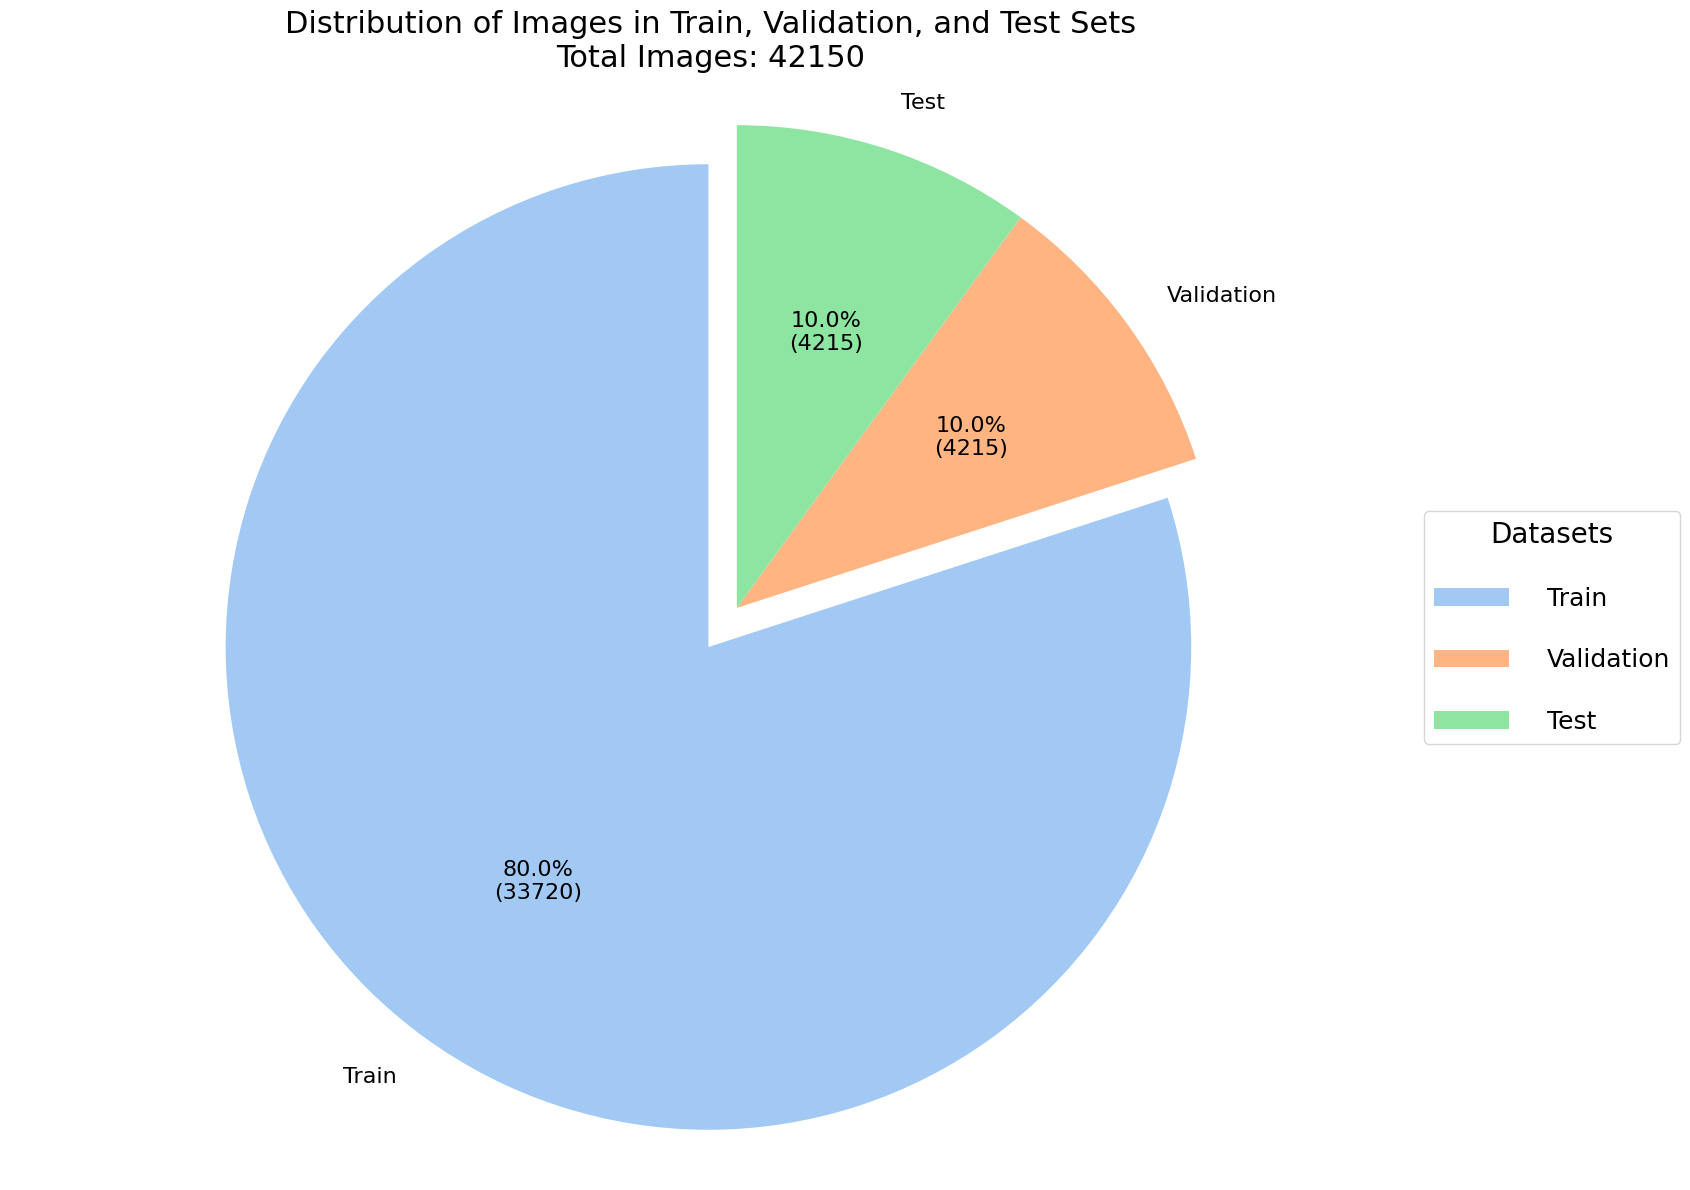

Pie chart has been saved as 'data_split_distribution.png'

Displaying resized images for ResNet50:


I0000 00:00:1720002344.379219      13 service.cc:145] XLA service 0x5a261fe1e220 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1720002344.379271      13 service.cc:153]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1720002344.379276      13 service.cc:153]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1720002344.379279      13 service.cc:153]   StreamExecutor device (2): TPU, 2a886c8
I0000 00:00:1720002344.379282      13 service.cc:153]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1720002344.379284      13 service.cc:153]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1720002344.379287      13 service.cc:153]   StreamExecutor device (5): TPU, 2a886c8
I0000 00:00:1720002344.379290      13 service.cc:153]   StreamExecutor device (6): TPU, 2a886c8
I0000 00:00:1720002344.379293      13 service.cc:153]   StreamExecutor device (7): TPU, 2a886c8


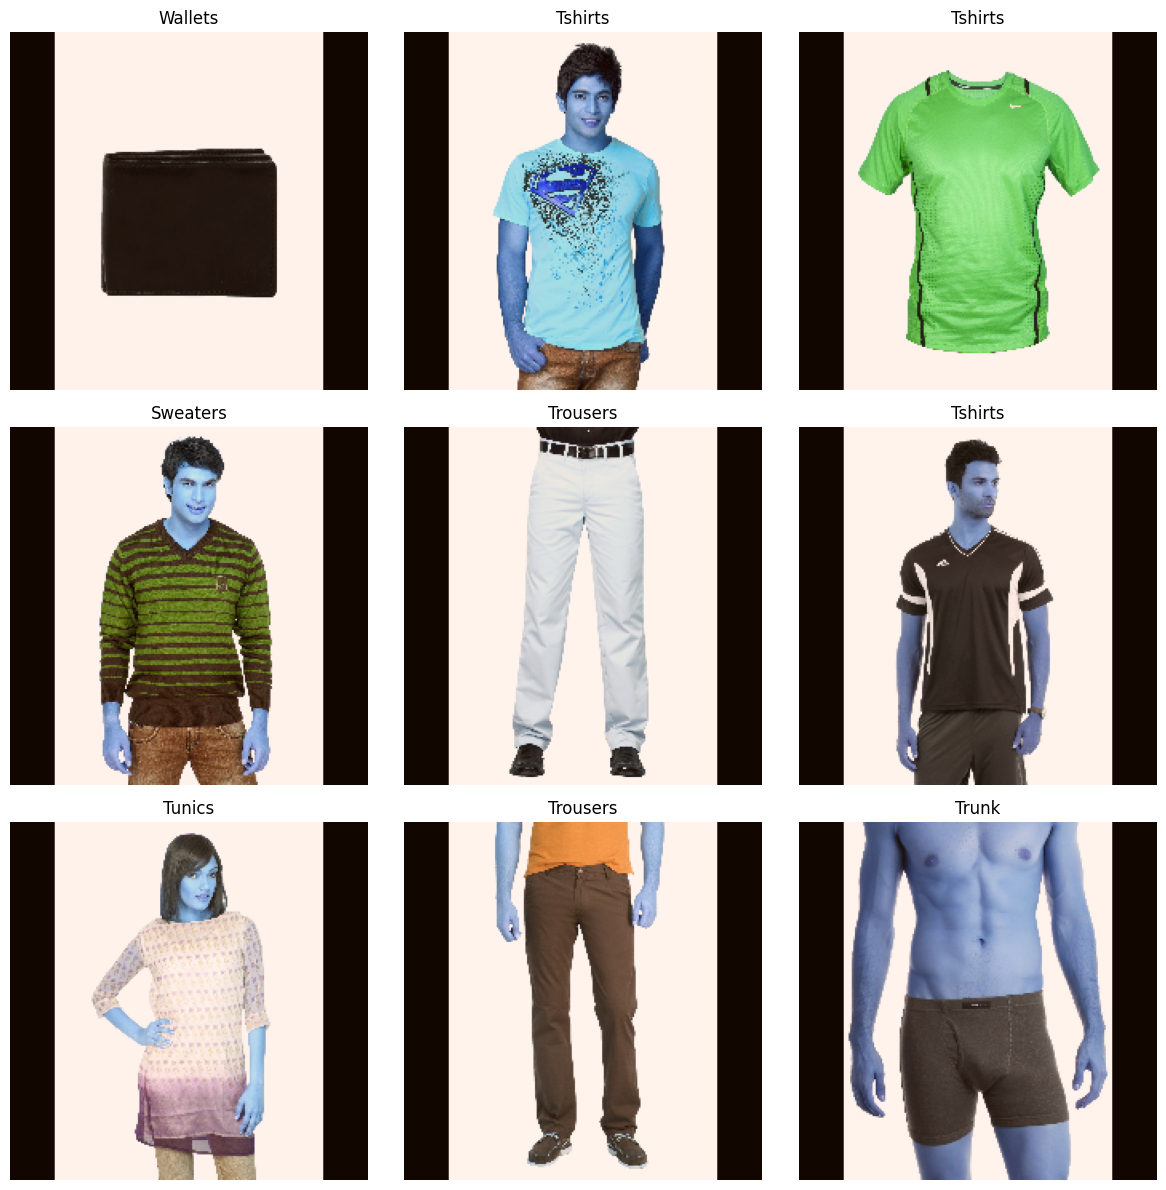


Displaying resized images for Xception:


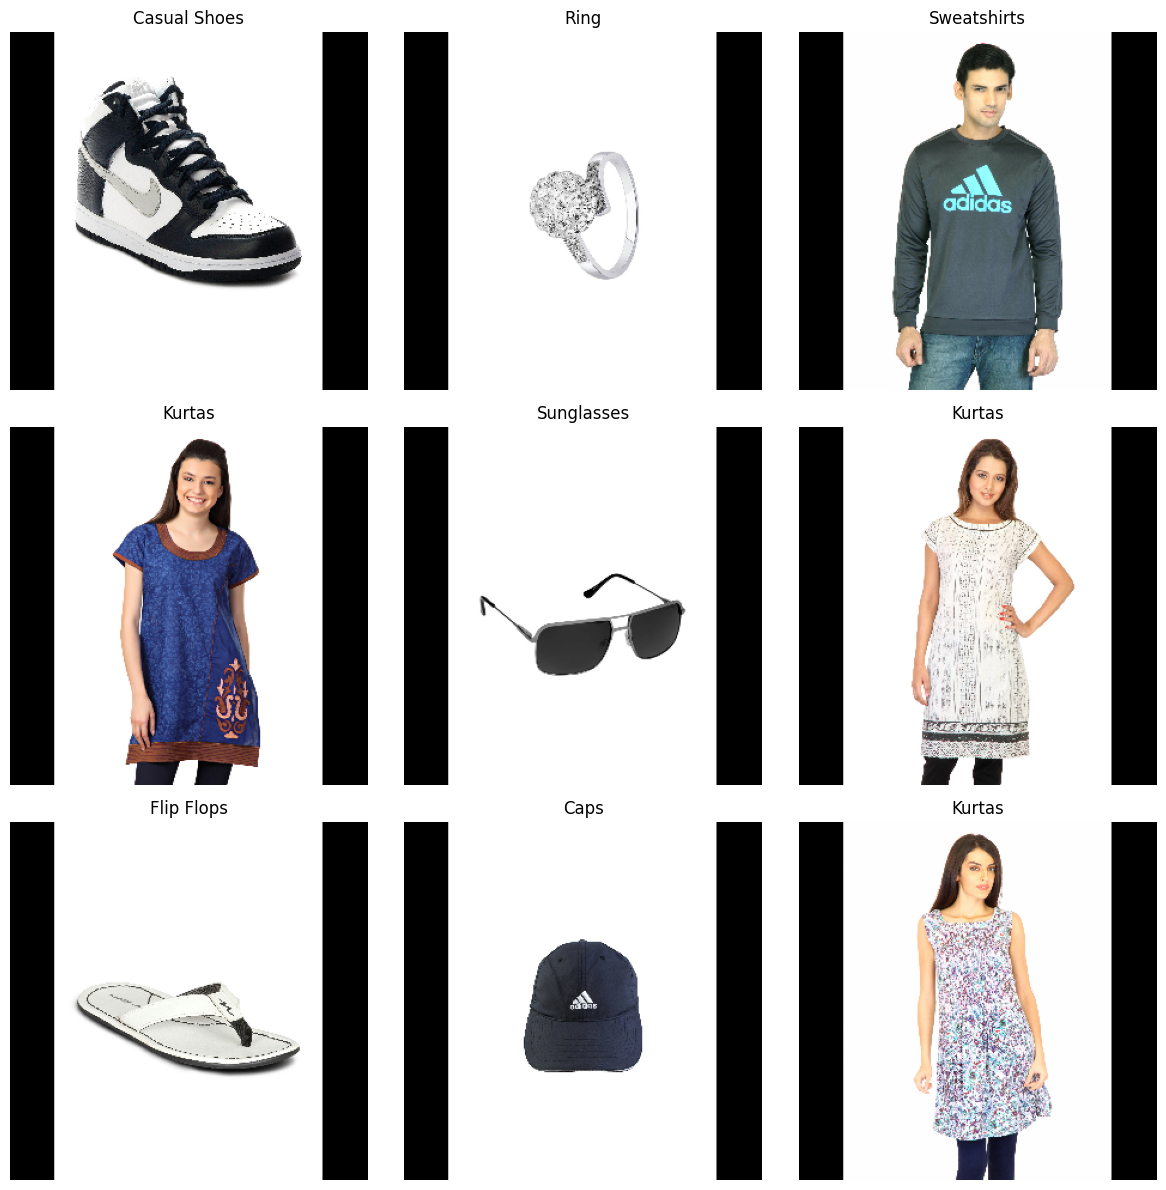


Displaying resized images for EfficientNetV2S:


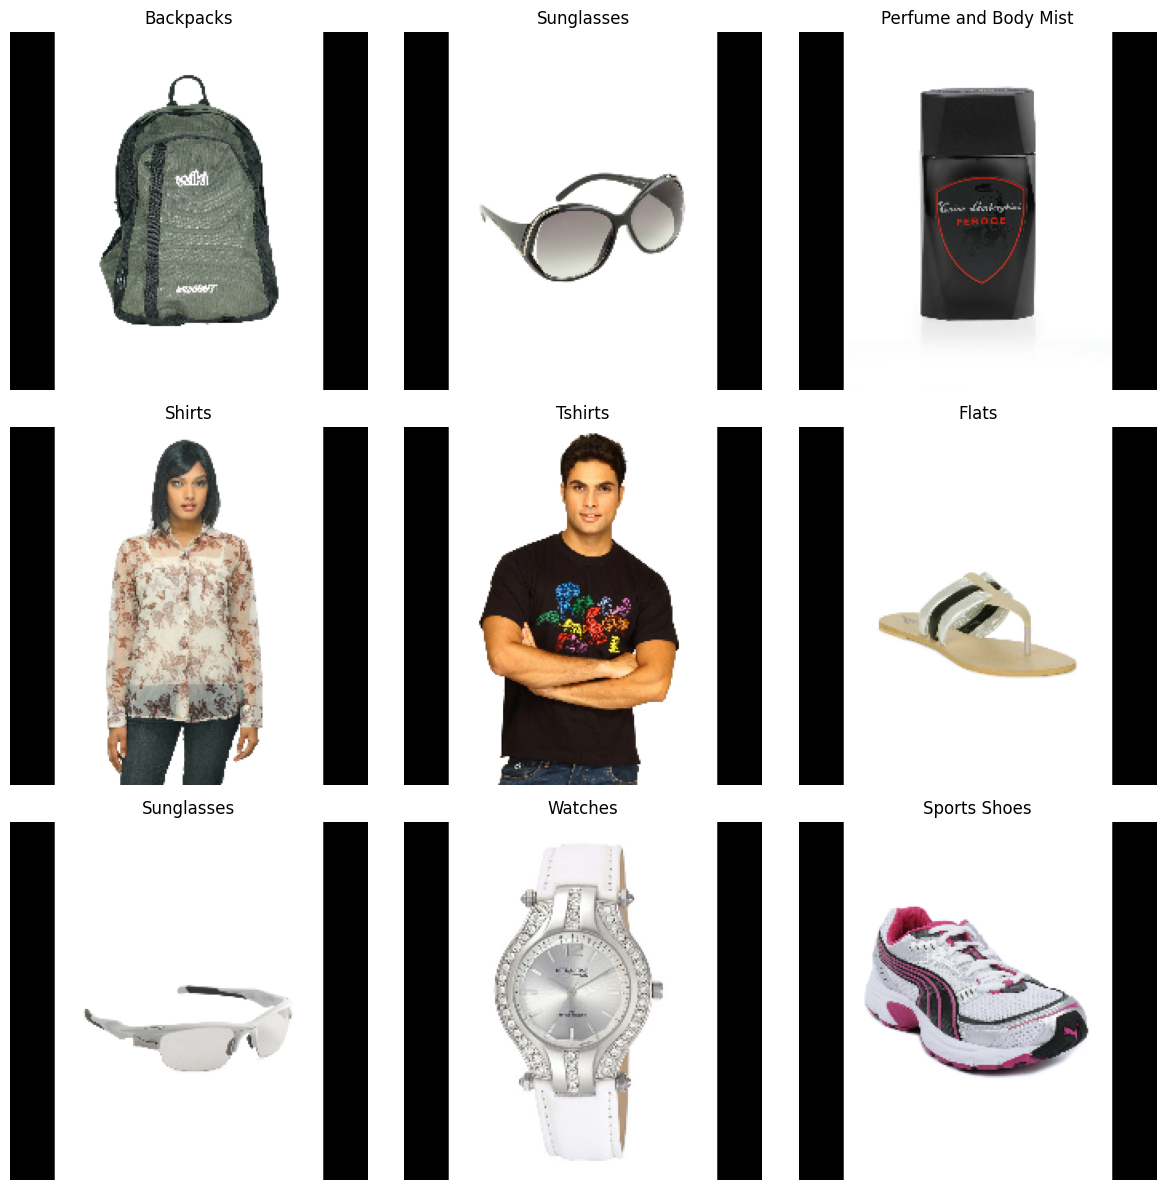


Displaying resized images for InceptionV3:


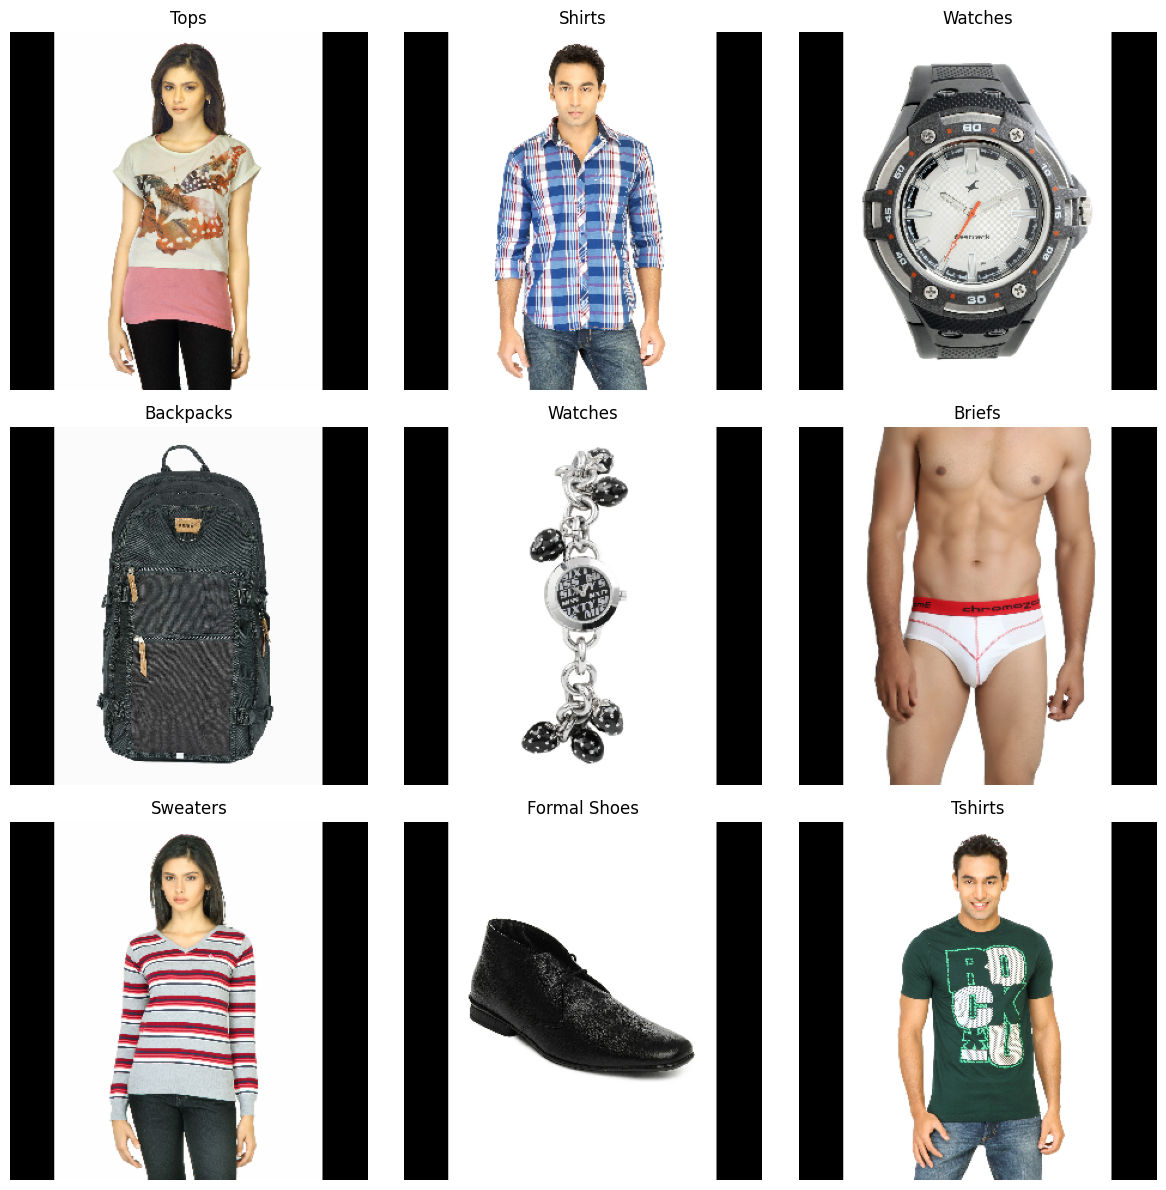

In [2]:
# Configuration
data_dir = "data/"
batch_size = 128
epochs = 30
models = ["EfficientNetV2S", "ResNet50", "Xception", "InceptionV3"]
model_configs = {
    "ResNet50": {"target_size": (224, 224), "preprocess_input": tf.keras.applications.resnet50.preprocess_input},
    "Xception": {"target_size": (299, 299), "preprocess_input": tf.keras.applications.xception.preprocess_input},
    "EfficientNetV2S": {
        "target_size": (224, 224),
        "preprocess_input": tf.keras.applications.efficientnet_v2.preprocess_input,
    },
    "InceptionV3": {"target_size": (299, 299), "preprocess_input": tf.keras.applications.inception_v3.preprocess_input},
}

# Load and preprocess data
train_df, val_df, test_df, total_images = load_and_preprocess_data(data_dir)

# Create a pie chart
plt.figure(figsize=(20, 12))  # Increased figure size
sizes = [len(train_df), len(val_df), len(test_df)]
labels = ['Train', 'Validation', 'Test']
colors = sns.color_palette("pastel")[0:3]

plt.pie(sizes, labels=labels, colors=colors, autopct=lambda pct: f'{pct:.1f}%\n({int(pct/100.*sum(sizes))})', 
        startangle=90, textprops={'fontsize': 16}, explode=(0.1, 0, 0))
plt.title(f'Distribution of Images in Train, Validation, and Test Sets\nTotal Images: {total_images}', fontsize=22)
plt.axis('equal')

# Add a much larger legend
plt.legend(title="Datasets", loc="center left", bbox_to_anchor=(1, 0.5), fontsize=18, title_fontsize=20, 
           labelspacing=1.5, handlelength=3, handletextpad=1.5)

# Adjust layout to make room for the legend
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust the right margin to accommodate the legend

# Save the pie chart
plt.savefig('data_split_distribution.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

print("Pie chart has been saved as 'data_split_distribution.png'")

# Save test dataset
test_df.to_csv('test_dataset.csv', index=False)

# Save model configurations
with open('model_configs.json', 'w') as f:
    json.dump({k: {**v, "preprocess_input": v["preprocess_input"].__name__} for k, v in model_configs.items()}, f)

# Save class labels
class_labels = np.unique(train_df["articleType"])
np.save('class_labels.npy', class_labels)

# Get a random sample of 9 images
for model_name, config in model_configs.items():
    print(f"\nDisplaying resized images for {model_name}:")

    # Get a random sample of 9 images
    sample_df = train_df.sample(n=9)

    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    for i, (_, row) in enumerate(sample_df.iterrows()):
        img = preprocess_image(row['image'], config['target_size'], config['preprocess_input'])
        img = img.numpy()

        # Denormalize the image for display
        img = (img - np.min(img)) / (np.max(img) - np.min(img))

        ax = axes[i // 3, i % 3]
        ax.imshow(img)
        ax.set_title(row['articleType'])
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Exploratory Data Analysis

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44424 entries, 0 to 44423
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  44424 non-null  int64  
 1   gender              44424 non-null  object 
 2   masterCategory      44424 non-null  object 
 3   subCategory         44424 non-null  object 
 4   articleType         44424 non-null  object 
 5   baseColour          44409 non-null  object 
 6   season              44403 non-null  object 
 7   year                44423 non-null  float64
 8   usage               44107 non-null  object 
 9   productDisplayName  44417 non-null  object 
dtypes: float64(1), int64(1), object(8)
memory usage: 3.4+ MB
None
                  id gender masterCategory subCategory articleType baseColour  \
count   44424.000000  44424          44424       44424       44424      44409   
unique           NaN      5              7          4

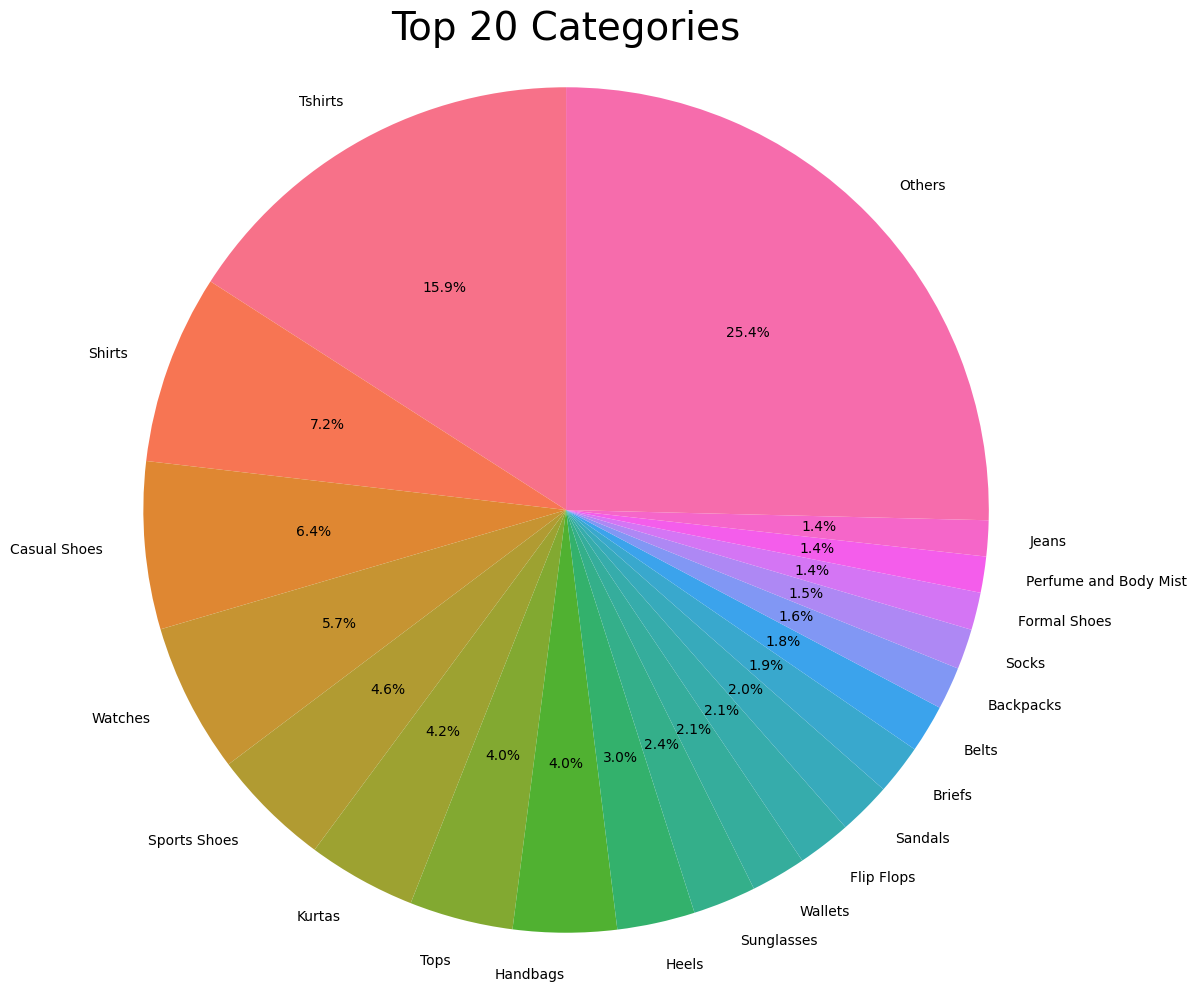

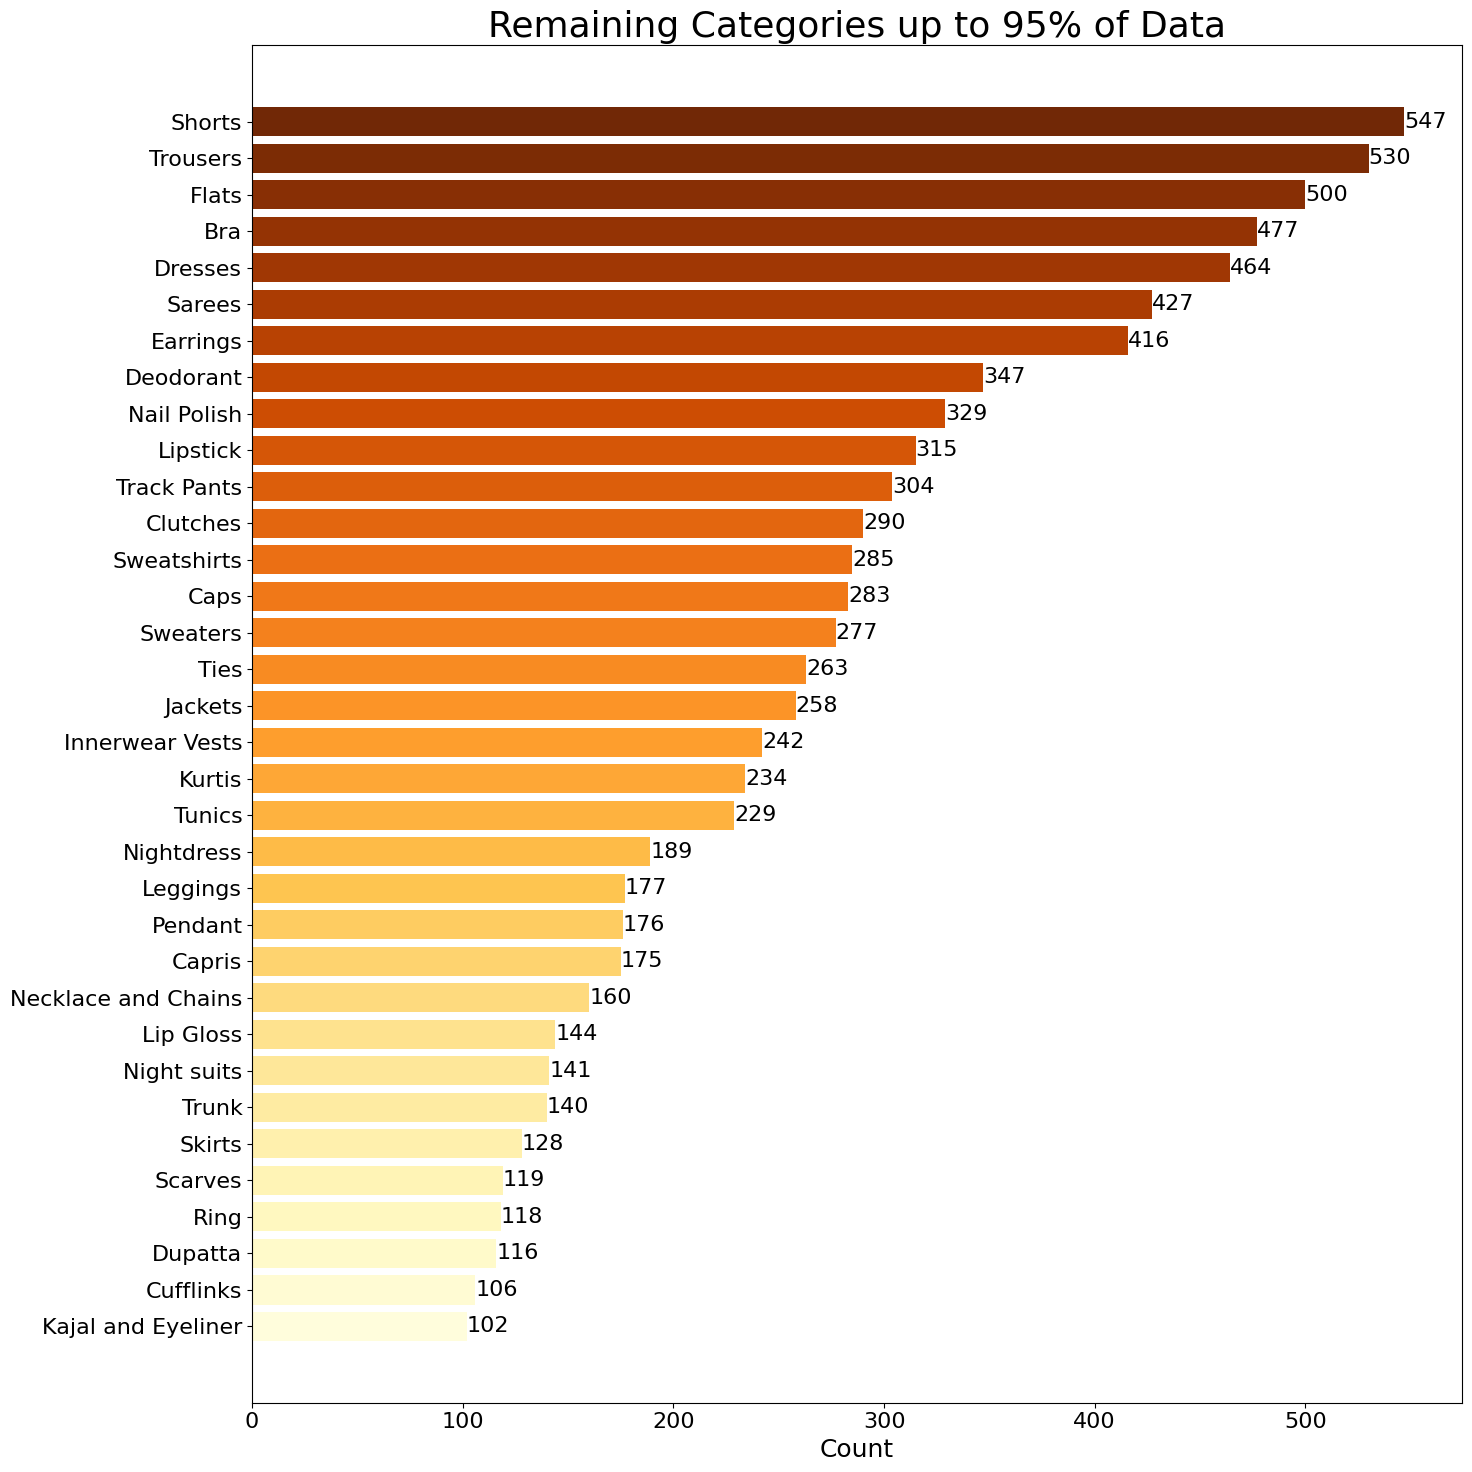

Charts have been saved as 'article_types_distribution_pie.png' and 'article_types_distribution_bar.png'

Classes representing 95% of the data:
1. Tshirts: 7067
2. Shirts: 3217
3. Casual Shoes: 2845
4. Watches: 2542
5. Sports Shoes: 2036
6. Kurtas: 1844
7. Tops: 1762
8. Handbags: 1759
9. Heels: 1323
10. Sunglasses: 1073
11. Wallets: 936
12. Flip Flops: 914
13. Sandals: 897
14. Briefs: 849
15. Belts: 813
16. Backpacks: 724
17. Socks: 686
18. Formal Shoes: 637
19. Perfume and Body Mist: 613
20. Jeans: 609
21. Shorts: 547
22. Trousers: 530
23. Flats: 500
24. Bra: 477
25. Dresses: 464
26. Sarees: 427
27. Earrings: 416
28. Deodorant: 347
29. Nail Polish: 329
30. Lipstick: 315
31. Track Pants: 304
32. Clutches: 290
33. Sweatshirts: 285
34. Caps: 283
35. Sweaters: 277
36. Ties: 263
37. Jackets: 258
38. Innerwear Vests: 242
39. Kurtis: 234
40. Tunics: 229
41. Nightdress: 189
42. Leggings: 177
43. Pendant: 176
44. Capris: 175
45. Necklace and Chains: 160
46. Lip Gloss: 144
47. Night suits: 141
4

In [3]:
# Load the dataset
file_path = 'data/styles.csv'
eda_df = pd.read_csv(file_path, on_bad_lines='skip')
eda_df = eda_df[['id', 'gender', 'masterCategory', 'subCategory', 'articleType', 'baseColour', 'season', 'year', 'usage', 'productDisplayName']]

# Display basic information about the dataset
print("Dataset Information:")
print(eda_df.info())
print(eda_df.describe(include='all'))

print("\nFirst few rows of the dataset:")
print(eda_df.head())

# Number of unique values in each column
print("\nNumber of unique values in each column:")
print(eda_df.nunique())


# Count the occurrences of each articleType
article_counts = eda_df['articleType'].value_counts()

# Total number of classes before preprocessing
total_classes = len(article_counts)

print(f"Total number of classes in 'articleType' before preprocessing: {total_classes}")

# Calculate the cumulative percentage
cumulative_percentage = 100 * article_counts.cumsum() / article_counts.sum()

# Find the number of classes that represent 95% of the data
classes_95_percent = (cumulative_percentage <= 95).sum()

print(f"Number of classes in 'articleType' representing 95% of the data: {classes_95_percent}")

def create_pie_and_bar_chart(data, title, filename, top_n=20):
    # Pie chart
    plt.figure(figsize=(12, 12))  # Reduced from (20, 20)
    top_categories = data.head(top_n)
    others = pd.Series({'Others': data.iloc[top_n:].sum()})
    pie_data = pd.concat([top_categories, others])
    
    colors = sns.color_palette("husl", len(pie_data))
    plt.pie(pie_data.values, labels=pie_data.index, autopct='%1.1f%%', startangle=90, colors=colors)
    plt.title(f'Top {top_n} Categories', fontsize=28)  # Increased from 24
    plt.axis('equal')
    
    # Increase font size for pie chart labels and percentages
    plt.rcParams['font.size'] = 16  # Increased from default
    
    plt.savefig(f'{filename}_pie.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

    # Bar chart
    plt.figure(figsize=(15, 15))  # Reduced from (20, 20)
    remaining_categories = data.iloc[top_n:classes_95_percent]
    remaining_categories = remaining_categories.sort_values(ascending=True)
    
    colors = sns.color_palette("YlOrBr", len(remaining_categories))
    bars = plt.barh(range(len(remaining_categories)), remaining_categories.values, color=colors)
    plt.yticks(range(len(remaining_categories)), remaining_categories.index, fontsize=16)  # Increased from 12
    plt.xlabel('Count', fontsize=18)  # Increased from 16
    plt.title(f'Remaining Categories up to 95% of Data', fontsize=26)  # Increased from 24
    
    # Add value labels to the end of each bar
    for bar in bars:
        width = bar.get_width()
        plt.text(width, bar.get_y() + bar.get_height()/2, f'{width}', 
                 ha='left', va='center', fontsize=16)  # Increased from 10
    
    plt.tight_layout()
    plt.savefig(f'{filename}_bar.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    
# Create charts for all classes up to 95%
create_pie_and_bar_chart(article_counts, 'Distribution of Article Types (95% of Data)', 'article_types_distribution')

print(f"Charts have been saved as 'article_types_distribution_pie.png' and 'article_types_distribution_bar.png'")

# Optional: Print the classes representing 95% of the data
classes = article_counts.index[:classes_95_percent].tolist()
print("\nClasses representing 95% of the data:")
for i, class_name in enumerate(classes, 1):
    print(f"{i}. {class_name}: {article_counts[class_name]}")



# Model Training

In [ ]:
# Detect and connect to a TPU if available
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print("Running on TPU ", tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy()

# Train and evaluate models
histories = {}
for model_name in models:
    print(f"Training {model_name} model...")

    config = model_configs[model_name]
    train_dataset = create_dataset(
        train_df,
        batch_size,
        config["target_size"],
        config["preprocess_input"],
        is_training=True,
    )
    val_dataset = create_dataset(
        val_df, batch_size, config["target_size"], config["preprocess_input"]
    )

    with strategy.scope():
        model = build_model(model_name, (*config["target_size"], 3), len(class_labels))
        history = train_model(model, model_name, train_dataset, val_dataset, epochs)
        histories[model_name] = history

    # Save training history
    with open(f'history_{model_name}.pkl', 'wb') as f:
        pickle.dump(history.history, f)



Running on TPU  
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local
INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/

I0000 00:00:1720002369.943453      13 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Epoch 1/30


2024-07-03 10:29:05.660485: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node StatefulPartitionedCall.
I0000 00:00:1720002551.450678     825 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(d24d3a8a83358ea:0:0), session_name()
I0000 00:00:1720002598.561973     825 tpu_compile_op_common.cc:245] Compilation of d24d3a8a83358ea:0:0 with session name  took 47.111232878s and succeeded
I0000 00:00:1720002598.732766     825 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(d24d3a8a83358ea:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_15478708426385491705", property.function_library_fingerprint = 7678485221581101315, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1

263/264 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.4262 - loss: 2.4370

I0000 00:00:1720002649.148848     837 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(cb134c27d388373:0:0), session_name()
I0000 00:00:1720002694.742000     837 tpu_compile_op_common.cc:245] Compilation of cb134c27d388373:0:0 with session name  took 45.593097883s and succeeded
I0000 00:00:1720002694.952104     837 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(cb134c27d388373:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_15478708426385491705", property.function_library_fingerprint = 7678485221581101315, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "7,224,224,3,;7,54,;", property.guaranteed_constants_size = 0, embedd

264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - accuracy: 0.4269 - loss: 2.4341

2024-07-03 10:31:41.062183: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignVariableOp.
I0000 00:00:1720002702.653861     811 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(ef040f2de747528:0:0), session_name()
I0000 00:00:1720002708.865619     811 tpu_compile_op_common.cc:245] Compilation of ef040f2de747528:0:0 with session name  took 6.211703517s and succeeded
I0000 00:00:1720002708.893847     811 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(ef040f2de747528:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_8366758947067104380", property.function_library_fingerprint = 7245004391265868030, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topolog


Epoch 1: val_accuracy improved from -inf to 0.78558, saving model to best_model_EfficientNetV2S.keras
264/264 ━━━━━━━━━━━━━━━━━━━━ 352s 468ms/step - accuracy: 0.4275 - loss: 2.4313 - val_accuracy: 0.7856 - val_loss: 0.7837 - learning_rate: 1.0000e-04
Epoch 2/30
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.7891 - loss: 0.7406
Epoch 2: val_accuracy improved from 0.78558 to 0.85389, saving model to best_model_EfficientNetV2S.keras
264/264 ━━━━━━━━━━━━━━━━━━━━ 59s 219ms/step - accuracy: 0.7892 - loss: 0.7403 - val_accuracy: 0.8539 - val_loss: 0.4569 - learning_rate: 1.0000e-04
Epoch 3/30
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.8299 - loss: 0.5460
Epoch 3: val_accuracy improved from 0.85389 to 0.86717, saving model to best_model_EfficientNetV2S.keras
264/264 ━━━━━━━━━━━━━━━━━━━━ 60s 223ms/step - accuracy: 0.8300 - loss: 0.5459 - val_accuracy: 0.8672 - val_loss: 0.3766 - learning_rate: 1.0000e-04
Epoch 4/30
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 

2024-07-03 10:55:33.814049: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node StatefulPartitionedCall.
I0000 00:00:1720004136.113807     819 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(88776249498b97d6:0:0), session_name()
I0000 00:00:1720004153.548192     819 tpu_compile_op_common.cc:245] Compilation of 88776249498b97d6:0:0 with session name  took 17.434321484s and succeeded
I0000 00:00:1720004153.626241     819 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(88776249498b97d6:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_5475241413258196631", property.function_library_fingerprint = 7941074832429954443, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z =

263/264 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.5275 - loss: 1.8644

I0000 00:00:1720004187.339373     752 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(2dfca6d997dbe75f:0:0), session_name()


264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - accuracy: 0.5281 - loss: 1.8620

I0000 00:00:1720004205.022993     752 tpu_compile_op_common.cc:245] Compilation of 2dfca6d997dbe75f:0:0 with session name  took 17.683577072s and succeeded
I0000 00:00:1720004205.084939     752 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(2dfca6d997dbe75f:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_5475241413258196631", property.function_library_fingerprint = 7941074832429954443, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "7,224,224,3,;7,54,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1720004205.084978     752 tpu_compilation_cache_interface.cc:541] After adding entry for key 


Epoch 1: val_accuracy improved from -inf to 0.76850, saving model to best_model_ResNet50.keras
264/264 ━━━━━━━━━━━━━━━━━━━━ 171s 262ms/step - accuracy: 0.5286 - loss: 1.8597 - val_accuracy: 0.7685 - val_loss: 0.8132 - learning_rate: 1.0000e-04
Epoch 2/30
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.8004 - loss: 0.6440
Epoch 2: val_accuracy did not improve from 0.76850
264/264 ━━━━━━━━━━━━━━━━━━━━ 39s 143ms/step - accuracy: 0.8004 - loss: 0.6440 - val_accuracy: 0.7590 - val_loss: 0.7303 - learning_rate: 1.0000e-04
Epoch 3/30
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.8250 - loss: 0.5711
Epoch 3: val_accuracy improved from 0.76850 to 0.83112, saving model to best_model_ResNet50.keras
264/264 ━━━━━━━━━━━━━━━━━━━━ 41s 153ms/step - accuracy: 0.8250 - loss: 0.5709 - val_accuracy: 0.8311 - val_loss: 0.5085 - learning_rate: 1.0000e-04
Epoch 4/30
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.8657 - loss: 0.4297
Epoch 4: val_accuracy improved from 0.83112 to

2024-07-03 11:15:52.963751: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node StatefulPartitionedCall.
I0000 00:00:1720005354.761521     792 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(ff8f0f4b7679769a:0:0), session_name()
I0000 00:00:1720005374.443312     792 tpu_compile_op_common.cc:245] Compilation of ff8f0f4b7679769a:0:0 with session name  took 19.681725061s and succeeded
I0000 00:00:1720005374.508462     792 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(ff8f0f4b7679769a:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_15156273265040704730", property.function_library_fingerprint = 10428354716470740654, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z

263/264 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.5136 - loss: 2.0688

I0000 00:00:1720005425.194775     834 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(d30ba47f530feef9:0:0), session_name()
I0000 00:00:1720005441.650164     834 tpu_compile_op_common.cc:245] Compilation of d30ba47f530feef9:0:0 with session name  took 16.455309263s and succeeded
I0000 00:00:1720005441.721744     834 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(d30ba47f530feef9:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_15156273265040704730", property.function_library_fingerprint = 10428354716470740654, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "7,299,299,3,;7,54,;", property.guaranteed_constants_size = 0, em

264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accuracy: 0.5142 - loss: 2.0658

2024-07-03 11:17:23.927369: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignVariableOp.
I0000 00:00:1720005444.616692     782 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(6627e12dff71716f:0:0), session_name()
I0000 00:00:1720005452.172140     782 tpu_compile_op_common.cc:245] Compilation of 6627e12dff71716f:0:0 with session name  took 7.55540439s and succeeded
I0000 00:00:1720005452.182477     782 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(6627e12dff71716f:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_15528002425508263906", property.function_library_fingerprint = 17446490571463423217, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, top


Epoch 1: val_accuracy improved from -inf to 0.84630, saving model to best_model_Xception.keras
264/264 ━━━━━━━━━━━━━━━━━━━━ 171s 344ms/step - accuracy: 0.5148 - loss: 2.0629 - val_accuracy: 0.8463 - val_loss: 0.4535 - learning_rate: 1.0000e-04
Epoch 2/30
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.8272 - loss: 0.5534
Epoch 2: val_accuracy improved from 0.84630 to 0.87476, saving model to best_model_Xception.keras
264/264 ━━━━━━━━━━━━━━━━━━━━ 56s 211ms/step - accuracy: 0.8272 - loss: 0.5533 - val_accuracy: 0.8748 - val_loss: 0.3806 - learning_rate: 1.0000e-04
Epoch 3/30
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - accuracy: 0.8612 - loss: 0.4341
Epoch 3: val_accuracy did not improve from 0.87476
264/264 ━━━━━━━━━━━━━━━━━━━━ 57s 214ms/step - accuracy: 0.8612 - loss: 0.4341 - val_accuracy: 0.8729 - val_loss: 0.3517 - learning_rate: 1.0000e-04
Epoch 4/30
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.8657 - loss: 0.4204
Epoch 4: val_accuracy improved from 0.87476 to

# Evaluation

In [ ]:
# Evaluation
test_results = {}
predicted_labels = {}
predicted_probabilities = {}

for model_name in models:
    print(f"Evaluating {model_name} model...")

    config = model_configs[model_name]
    test_dataset = create_dataset(
        test_df, batch_size, config["target_size"], config["preprocess_input"]
    )

    # Load the best model
    model = tf.keras.models.load_model(f"best_model_{model_name}.keras")
    test_loss, test_accuracy = model.evaluate(test_dataset, verbose=1)
    test_results[model_name] = {'loss': test_loss, 'accuracy': test_accuracy}

    predictions = model.predict(test_dataset)
    predicted_classes = np.argmax(predictions, axis=1)
    predicted_labels[model_name] = predicted_classes
    predicted_probabilities[model_name] = predictions

    print(f"{model_name} Test Loss: {test_loss:.4f}")
    print(f"{model_name} Test Accuracy: {test_accuracy * 100:.2f}%")

# True labels
true_labels = np.argmax(pd.get_dummies(test_df["articleType"]).values, axis=1)

# Print classification report for each model
for model_name in models:
    print(f"Classification Report for {model_name}:")
    print(classification_report(true_labels, predicted_labels[model_name], target_names=class_labels))

# Plot confusion matrix for each model
for model_name in models:
    cm = confusion_matrix(true_labels, predicted_labels[model_name])
    plt.figure(figsize=(30, 25))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(f'artifacts/confusion_matrix_{model_name}.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

# Compare model performance
print("Model Performance Comparison:")
for model_name, result in test_results.items():
    print(f"{model_name}: Test Loss = {result['loss']:.4f}, Test Accuracy = {result['accuracy'] * 100:.2f}%")

# Plot Precision-Recall curve and calculate AUPRC for each model
macro_auprcs = {}
for model_name in models:
    macro_auprcs[model_name] = plot_macro_average_prc_curve(true_labels, predicted_probabilities[model_name], class_labels, model_name)

# Print macro-average AUPRC scores for all models
print("\nMacro-Average AUPRC Scores:")
for model_name, auprc_score in macro_auprcs.items():
    print(f"{model_name}: {auprc_score:.4f}")

# Plot training history for all models
for model_name, history in histories.items():
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='validation')
    plt.title(f'{model_name} - Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.title(f'{model_name} - Loss')
    plt.legend()

    plt.savefig(f'artifacts/training_history_{model_name}.png')
    plt.show()
    plt.close()

print("Evaluation completed for all models.")
print(f"Class labels: {class_labels}")

# Identify the best performing model
best_model = max(test_results, key=lambda x: test_results[x]['accuracy'])
print(f"\nBest performing model: {best_model}")
print(f"Best model accuracy: {test_results[best_model]['accuracy'] * 100:.2f}%")

# Additional analysis for the best model
best_model_predictions = predicted_labels[best_model]

# Top misclassified classes
misclassified = true_labels != best_model_predictions
misclassified_df = pd.DataFrame({
    'True': [class_labels[i] for i in true_labels[misclassified]],
    'Predicted': [class_labels[i] for i in best_model_predictions[misclassified]]
})
top_misclassified = misclassified_df.groupby(['True', 'Predicted']).size().sort_values(ascending=False).head(10)

print("\nTop 10 misclassified pairs:")
print(top_misclassified)

# Save top misclassified pairs
top_misclassified.to_csv('artifacts/top_misclassified.csv')

# Class-wise accuracy
class_accuracy = classification_report(true_labels, best_model_predictions, target_names=class_labels, output_dict=True)
class_accuracy_df = pd.DataFrame(class_accuracy).transpose()
class_accuracy_df = class_accuracy_df.sort_values('f1-score', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=class_accuracy_df.index, y=class_accuracy_df['f1-score'])
plt.title('F1-score by Class for Best Model')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('artifacts/f1_score_by_class.png')
plt.show()
plt.close()

print("\nAnalysis completed. All results and visualizations have been saved.")